# Learn to Rank
https://www.tensorflow.org/ranking/tutorials/quickstart

https://www.geeksforgeeks.org/train-a-model-using-lightgbm/#
https://gist.github.com/darcyabjones/ace0934ae19c56ed4babc50167f282b0#file-ltr_presentation-ipynb
https://hav4ik.github.io/learning-to-rank/

In [172]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [173]:
# load up full data
complete = pd.read_csv('https://scmcqueen.github.io/StarTrekScriptData/complete_data.csv').reset_index()
complete.columns = ['index','line','character', 'quote', 'scene', 'location', 'view',
       'episode', 'date', 'series', 'file']
complete['quote']=complete['quote'].apply(lambda text: " ".join(text.split()))
complete['character']=complete['character'].fillna('NA')
complete.head()

,index,line,character,quote,scene,location,view,episode,date,series,file
0,0,0,QUARK,"You know, Morn -- there's nothing quite as inv...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
1,1,1,ROM,What's this?,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
2,2,2,QUARK,"What do you mean, ""what's this?"" It's puree of...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
3,3,3,ROM,I didn't order it.,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
4,4,4,QUARK,"Of course you ""didn't order it"" -- you don't n...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt


In [174]:
# load up ratings
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)


In [175]:
# now we need to merge them

# drop the quote & unnamed 0
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
ratings.columns = ['index','query','ranking']
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
full_data = ratings.merge(complete,on=['index'],how='left')

In [189]:
full_data

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file
0,66191,men,17,333,LARELL,Two men.,34 INT. QUARK'S QUARTERS,QUARK'S QUARTERS,INT.,Who Mourns for Morn?,1997-10-28,Deep Space Nine,536.txt
1,120092,men,5,171,RIKER,What about the men?,20A INT. CARGO HOLD,CARGO HOLD,INT.,Up the Long Ladder,1989-03-17,The Next Generation,144.txt
2,46258,men,1,287,EZRI,Because they're men.,38 INT. QUARK'S - ON SARINA,QUARK',INT.,Chrysalis,1998-08-14,Deep Space Nine,555.txt
3,60897,men,17,250,BASHIR,They're your own men.,64 INT. JEM'HADAR CAVERN - DAY,JEM'HADAR CAVER,INT.,Rocks and Shoals,1997-07-24,Deep Space Nine,527.txt
4,1085,men,17,237,HERBERT,And men from Mars are?,33 INT. MAGAZINE OFFICE - DAY,MAGAZINE OFFIC,INT.,Far Beyond the Stars,1997-11-14,Deep Space Nine,538.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,95494,colony,4,82,KENTOR,But the colony survived -- and prospered.,11 EXT. PLANET SURFACE - MAIN STREET - DAY,PLANET SURFAC,EXT.,The Ensigns of Command,1989-07-13,The Next Generation,149.txt
1129,110032,colony,17,64,RIKER,Let's hope they stay clear of the colony.,8 INT. BRIDGE (OPTICAL),BRIDGE,INT.,Legacy,1990-08-20,The Next Generation,180.txt
1130,102026,colony,17,69,PICARD,Continue hailing the colony. All channels.,22 INT. BRIDGE,BRIDGE,INT.,Silicon Avatar,1991-07-31,The Next Generation,204.txt
1131,101997,colony,17,40,PICARD,See if you can make contact with the colony...,17 INT. BRIDGE,BRIDGE,INT.,Silicon Avatar,1991-07-31,The Next Generation,204.txt


In [176]:
# train test split my data
train, test = train_test_split(full_data,test_size=.2,random_state=56)
# sort my train values
train = train.sort_values('query')
test = test.sort_values('query')

In [177]:
train_y = list(train['ranking']) # made a list instead of series
train_X = train.drop(columns=['query','ranking','quote','date','scene'])
groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

In [178]:
train_X.sample(2)

,index,line,character,location,view,episode,series,file
700,18242,14,SISKO,SISKO'S QUARTERS,INT.,CAST,Deep Space Nine,567.txt
29,74907,14,WORF,ENTERPRISE MAIN BRIDGE,INT.,Angel One,The Next Generation,115.txt


In [179]:
enc = OneHotEncoder(handle_unknown='ignore')

X=enc.fit_transform(train_X)


In [180]:
train_X

,index,line,character,location,view,episode,series,file
775,15633,439,SISKO,COMMANDER'S OFFICE,INT.,Heart of Stone,Deep Space Nine,460.txt
781,44235,292,O'BRIEN,PROMENAD,INT.,Whispers,Deep Space Nine,434.txt
788,55684,398,ISHKA,ISHKA'S HOUSE - LIVING ROOM,INT.,Ferengi Love Songs,Deep Space Nine,518.txt
777,36208,320,PEL,FERENGI SHIP,INT.,Rules of Acquisition,Deep Space Nine,427.txt
782,24556,127,QUARK,QUARK'S QUARTER,INT.,The Nagus,Deep Space Nine,411.txt
...,...,...,...,...,...,...,...,...
61,21066,326,MARTOK,KLINGON WARDROOM,INT.,Tacking into the Wind,Deep Space Nine,572.txt
70,131480,274,TASHA,CORRIDOR,INT.,Heart Of Glory,The Next Generation,120.txt
67,140167,128,RIKER,BRIDGE,INT.,The Chase,The Next Generation,246.txt
69,132842,167,RIKER,OBSERVATION LOUNGE,INT.,Liaisons,The Next Generation,254.txt


In [181]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [182]:
test_y = list(test['ranking'])
test_X = test.drop(columns=['query','ranking','quote','date','scene'])
t_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values
t_X = enc.transform(test_X)

In [186]:
train_data =lgb.Dataset(X, label=train_y, group=groups,)
valid_data = lgb.Dataset(t_X,label=test_y,group=t_groups)

In [187]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'task':'train',
    # 'feature_pre_filter':False,
    'min_data_in_leaf':30
}
res = {}

In [188]:
ranker = lgb.train(params, train_data, num_boost_round=250,valid_sets=[valid_data])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

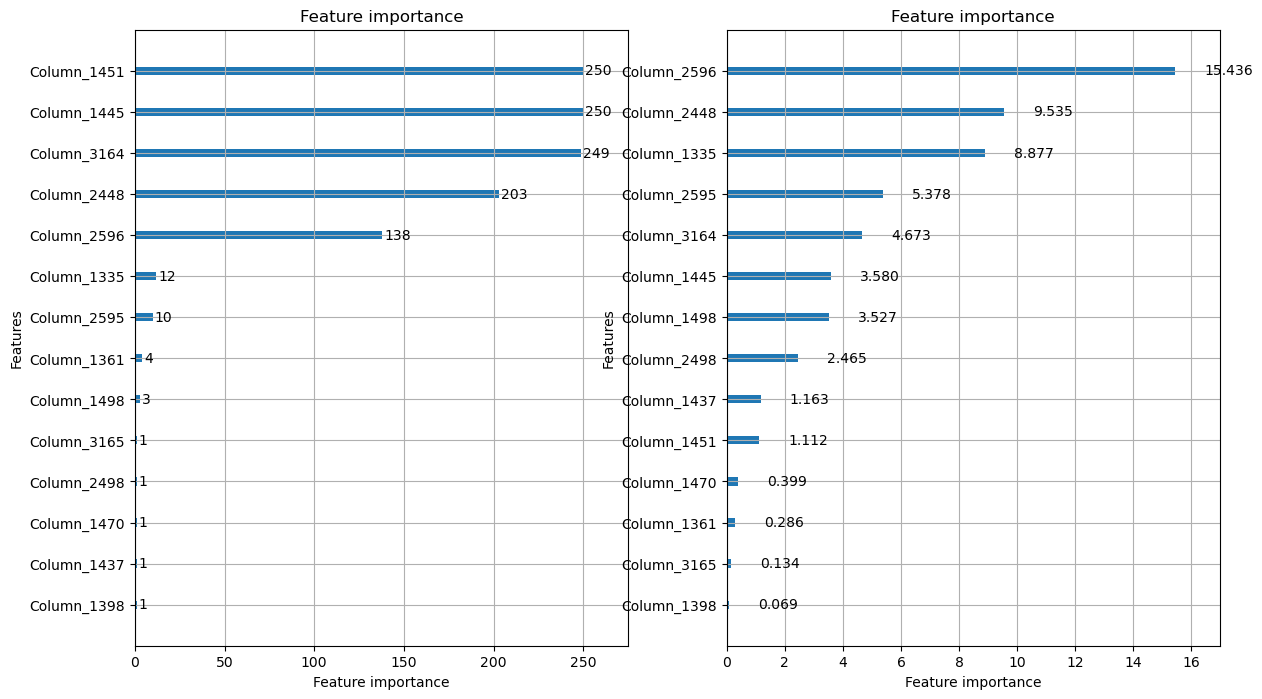

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)